In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
from graphics import ClassGraphics
import os

# parameters
path_results = "./results/empirical_results/"
Graphics = ClassGraphics(None,plot_period=1000)

# 1 data preprocessing

In [2]:
# load fake data (exposure)
df_exposures = ef.get_df_exposures(lines=int(1e5))
dic_rev_repo_exp_adj = ep.build_from_exposures(df_exposures=df_exposures,path=f"{path_results}data/")

# build finrep data @NA: add here a read csv of the data with the total assets
df_finrep = ef.get_df_finrep()

100%|██████████| 100000/100000 [00:32<00:00, 3032.21it/s]


In [3]:
# pickle (faster)
dic_rev_repo_exp_adj = ep.load_dic_obs_matrix_reverse_repo(path=f"{path_results}data/")
df_finrep = ef.get_df_finrep()

# 2 metrics measurement

## 2.1 accounting view

In [4]:
# build arr_total_assets
arr_total_assets = ep.build_arr_total_assets(df_finrep, f"{path_results}exposure_view/degree_per_asset/")

## 2.2. exposure view

In [5]:
os.makedirs(f"{path_results}exposure_view/", exist_ok=True)

In [6]:
# get aggregated adjency matrices
dic_arr_binary_adj = ep.build_rolling_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=f"{path_results}data/")

In [7]:
# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=f"{path_results}data/")

### 2.2.1 jaccard

In [8]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=path_results)
Graphics.plot_trajectory(
            df=df_jaccard,
            cols=[
                f"jaccard index-{agg_period}" for agg_period in par.agg_periods
            ],
            title="Jaccard index",
            file_name=f"{path_results}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 20833/20833 [00:04<00:00, 4327.98it/s]


### 2.2.2 density

In [9]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=path_results)
Graphics.plot_trajectory(
            df=df_density,
            cols=[
                f"network density-{agg_period}"
                for agg_period in par.agg_periods
            ],
            title="Network density",
            file_name=f"{path_results}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 20833/20833 [00:04<00:00, 4438.16it/s]


### 2.2.3 degree distribution 

In [10]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path_results}exposure_view/degree_distribution/")
Graphics.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    f"{path_results}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 20834/20834 [00:11<00:00, 1879.51it/s]


### 2.2.4 av. degree

In [11]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_av_degree = em.get_av_degree(dic_degree, days, path=path_results)
Graphics.plot_trajectory(
            df=df_av_degree,
            cols=[
                f"av. degree-{agg_period}" for agg_period in par.agg_periods
            ],
            title="Av. degree",
            file_name=f"{path_results}exposure_view/average_degree.pdf",
        )

get av. degree


100%|██████████| 20833/20833 [00:04<00:00, 4275.73it/s]


### 2.2.5 degree per asset

In [12]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep["date"])
finrep_bank_ids = list(set(df_finrep["lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
Graphics.plot_degree_per_asset(arr_total_assets,dic_degree,bank_ids,days,f"{path_results}exposure_view/degree_per_asset/",plot_days=plot_days,finrep_days=finrep_days, finrep_bank_ids=finrep_bank_ids)

### 2.2.6 core periphery

In [13]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# run cp tests
Graphics.plot_cp_test(dic_arr_binary_adj, algos=par.cp_algos,days=days, path_results=f"{path_results}exposure_view/", opt_agg=True)
Graphics.plot_cp_test(arr_rev_repo_exp_adj, algos=par.cp_algos, days=days, path_results=f"{path_results}exposure_view/", opt_agg=False)

run core-periphery tests
core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 191.37it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1029.53it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1053.60it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 884.41it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 953.28it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1046.40it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1049.53it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1049.73it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 959.02it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1053.17it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1064.59it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1058.25it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1061.09it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1063.36it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1062.42it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1065.84it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 893.70it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1020.97it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 937.33it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1054.56it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1058.31it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1011.55it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 596.64it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 557.44it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 567.95it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.43it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 574.64it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.49it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.59it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 557.18it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.95it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 555.87it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 559.51it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 558.73it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 558.51it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 555.19it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 554.05it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 553.77it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.23it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 557.47it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.67it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 567.09it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.81it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 569.05it/s]


core-periphery tests using the LapSgnCore approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 617.89it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.57it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.77it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.72it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 572.47it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 576.18it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.69it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 135.98it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.41it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.90it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 568.09it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.99it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.89it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 568.27it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 569.40it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 559.13it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 567.59it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 568.47it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 569.10it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.27it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.54it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 564.55it/s]


core-periphery tests using the MINRES approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 51.08it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.92it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.33it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:02<00:00, 33.78it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.35it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.27it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:03<00:00, 31.43it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.30it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:03<00:00, 29.86it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:03<00:00, 29.78it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:03<00:00, 29.01it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:02<00:00, 33.37it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:03<00:00, 28.89it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:03<00:00, 31.22it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:03<00:00, 31.19it/s]


core-periphery tests using the Lip approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3653.70it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2733.37it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2740.10it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2733.39it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2745.30it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2720.54it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2734.78it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2735.21it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2746.98it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2737.14it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2780.98it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2743.58it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2724.94it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2711.39it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2698.26it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2712.86it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2753.47it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2682.98it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2779.14it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2740.60it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2787.58it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2601.44it/s]


core-periphery tests using the BE approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1662.30it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1076.93it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1056.66it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1093.14it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1062.26it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 120.51it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1056.23it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1058.03it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1071.30it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1075.85it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1091.77it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1075.44it/s]

test on day 2052-11-08 00:00:00



100%|██████████| 100/100 [00:00<00:00, 1118.17it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1122.07it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1060.46it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1090.71it/s]

test on day 2063-10-22 00:00:00

100%|██████████| 100/100 [00:00<00:00, 1115.13it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1112.34it/s]

test on day 2069-04-13 00:00:00



100%|██████████| 100/100 [00:00<00:00, 1174.36it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1095.94it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1091.25it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1053.65it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 192.30it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.27it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.25it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.19it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.22it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.26it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.02it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.28it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.16it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.17it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.10it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.15it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.05it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.01it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.17it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.10it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.12it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.07it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.06it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.03it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 612.74it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.41it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.97it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.32it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.62it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.19it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.84it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.21it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.06it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.91it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.46it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.63it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.33it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.37it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.78it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.42it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.70it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.71it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.28it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.23it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.44it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.91it/s]


core-periphery tests using the LapSgnCore approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 615.78it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.62it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.47it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.43it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.59it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.60it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.20it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.00it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.37it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.83it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.16it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.48it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 537.10it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.16it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.52it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.11it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.95it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.51it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.79it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.00it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.90it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.87it/s]


core-periphery tests using the MINRES approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 51.14it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.09it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.18it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.11it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.72it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.05it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.62it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.20it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.63it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.68it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.01it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.64it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.99it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.67it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.44it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.37it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:01<00:00, 70.09it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.25it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.39it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.79it/s]


core-periphery tests using the Lip approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3930.49it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2233.97it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2278.89it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2271.72it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2256.87it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2268.47it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2280.01it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2261.56it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2254.03it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2277.41it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2263.64it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2242.21it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2274.99it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2270.66it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2266.13it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2245.73it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2276.83it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2261.08it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2252.73it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2275.48it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2261.86it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2256.03it/s]


core-periphery tests using the BE approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1737.43it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 930.90it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 860.58it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 925.41it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 936.83it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.85it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 926.87it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 928.01it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.27it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 932.42it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 933.09it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 913.79it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 911.42it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 919.33it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.58it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 926.40it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 920.77it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 935.44it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 914.34it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.89it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 925.77it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 910.06it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 192.52it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.15it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.28it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.32it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.20it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.51it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.47it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.54it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.64it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.00it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.12it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.13it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.07it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.02it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.21it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.29it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.23it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.21it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 587.58it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.81it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.15it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.23it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.27it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.50it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.77it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.76it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.23it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.84it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.37it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.61it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.26it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.77it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.50it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.77it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.42it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.87it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.62it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.48it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.42it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.54it/s]


core-periphery tests using the LapSgnCore approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 620.87it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.12it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.29it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.97it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.59it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.77it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.99it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.11it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 536.13it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.45it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.73it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 534.86it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.11it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.83it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.62it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.75it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.03it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.74it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.72it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.40it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.63it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.11it/s]


core-periphery tests using the MINRES approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 51.45it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.92it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.97it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.59it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.13it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.67it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.83it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.85it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:01<00:00, 70.01it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.56it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:01<00:00, 70.02it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.64it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.69it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.28it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 70.00it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.27it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.15it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.42it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.60it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.11it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.73it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.32it/s]


core-periphery tests using the Lip approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3869.96it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2264.85it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2236.04it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2278.76it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2272.18it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2230.80it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2292.30it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2277.82it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2253.17it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2281.41it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2272.20it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2245.04it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2261.92it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2271.51it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2261.89it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2270.20it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2278.44it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2248.58it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2288.12it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2275.25it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2239.97it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2286.75it/s]


core-periphery tests using the BE approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1749.12it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 898.64it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 931.75it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 928.04it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.98it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.33it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 933.21it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.28it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 930.22it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 933.84it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 930.33it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 931.25it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 892.16it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 926.41it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 916.77it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.37it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 931.82it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 926.93it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 925.70it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 886.10it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 849.38it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 873.08it/s]


core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 192.48it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.23it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 106.53it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.31it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.35it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.29it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.44it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.09it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.35it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.28it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.38it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.30it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.39it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.46it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.34it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.33it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 107.36it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 594.25it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 549.94it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.92it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.03it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.55it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.17it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.73it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.74it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.69it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.25it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.48it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.90it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.85it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 546.79it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.57it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.28it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 547.69it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.07it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 548.25it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 544.19it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 543.48it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 545.49it/s]


core-periphery tests using the LapSgnCore approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 618.19it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.37it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.67it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.77it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.25it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.22it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.62it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.66it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.14it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.25it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.43it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.57it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.23it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 539.22it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.13it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.77it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.16it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 538.71it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.79it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 540.53it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 542.12it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 541.31it/s]


core-periphery tests using the MINRES approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 51.33it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:01<00:00, 67.94it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.42it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:01<00:00, 70.00it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.51it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.81it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.26it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.52it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.37it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.59it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.11it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.68it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.52it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.95it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.01it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.89it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.84it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.54it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.07it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:01<00:00, 69.40it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.87it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:01<00:00, 68.83it/s]


core-periphery tests using the Lip approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 3947.39it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2262.98it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2263.52it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2223.50it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2238.14it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2250.36it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2244.55it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2265.87it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2263.23it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2251.27it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2256.34it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2274.10it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2245.04it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2264.91it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2266.73it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2251.43it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2276.11it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2278.18it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2268.55it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2284.01it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2273.18it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2272.20it/s]


core-periphery tests using the BE approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1762.01it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 937.81it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 935.28it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 924.02it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 928.41it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 929.39it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 928.68it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 929.28it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 919.10it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.69it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 894.37it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 903.54it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 921.15it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 928.25it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 923.96it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 926.12it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 925.49it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 911.59it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.28it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 930.06it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 920.98it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 927.22it/s]


run core-periphery tests
core-periphery tests using the Rombach approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1040.78it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 966.13it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1038.11it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1067.05it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1048.38it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1027.55it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1043.61it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1049.21it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1039.42it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1048.59it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1054.08it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1044.73it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 994.90it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1012.91it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1045.40it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 955.47it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1049.94it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1051.20it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1051.15it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1050.94it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1047.00it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.58it/s]


core-periphery tests using the Rossa approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 552.32it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 564.98it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 564.67it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 553.68it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 553.53it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 552.35it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 553.70it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 554.46it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.65it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 568.49it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.37it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.38it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.35it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 563.27it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.90it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 574.36it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.22it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 551.69it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 556.11it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 566.06it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 565.93it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 563.39it/s]


core-periphery tests using the LapSgnCore approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 572.06it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.68it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.19it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 572.63it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.96it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.06it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 573.24it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 569.50it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.73it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 572.93it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.76it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.29it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.14it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.94it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 572.88it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 570.56it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.67it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.45it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 574.92it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 571.97it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 569.54it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 581.97it/s]


core-periphery tests using the MINRES approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.54it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.26it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.21it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.24it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.59it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:02<00:00, 35.96it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.77it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.16it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:02<00:00, 36.63it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.08it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.19it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:02<00:00, 34.41it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.40it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.18it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:02<00:00, 38.53it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.12it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.18it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:02<00:00, 37.90it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


core-periphery tests using the Lip approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2699.35it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2885.52it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2709.83it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2745.09it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2700.24it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2726.12it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2697.23it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2698.97it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2706.25it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2717.59it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2751.82it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2664.84it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2663.95it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2675.98it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2674.70it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2715.09it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2807.96it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2691.37it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2721.40it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2694.37it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2689.16it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 2935.54it/s]


core-periphery tests using the BE approach
test on day 2020-01-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1115.54it/s]


test on day 2022-09-27 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1073.90it/s]


test on day 2025-06-23 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1092.55it/s]


test on day 2028-03-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1072.75it/s]


test on day 2030-12-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1075.34it/s]


test on day 2033-09-09 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1091.83it/s]


test on day 2036-06-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1085.31it/s]


test on day 2039-03-02 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1100.97it/s]


test on day 2041-11-26 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1081.81it/s]


test on day 2044-08-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1065.83it/s]


test on day 2047-05-19 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1068.18it/s]


test on day 2050-02-12 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1059.88it/s]


test on day 2052-11-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1089.70it/s]


test on day 2055-08-05 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1093.45it/s]


test on day 2058-05-01 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1060.46it/s]


test on day 2061-01-25 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1081.13it/s]


test on day 2063-10-22 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1072.77it/s]


test on day 2066-07-18 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1083.18it/s]


test on day 2069-04-13 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1102.11it/s]


test on day 2072-01-08 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1073.13it/s]


test on day 2074-10-04 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1084.92it/s]


test on day 2077-01-14 00:00:00


100%|██████████| 100/100 [00:00<00:00, 1207.53it/s]


## 2.3 transaction view

In [14]:
os.makedirs(f"{path_results}transaction_view/", exist_ok=True)

# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

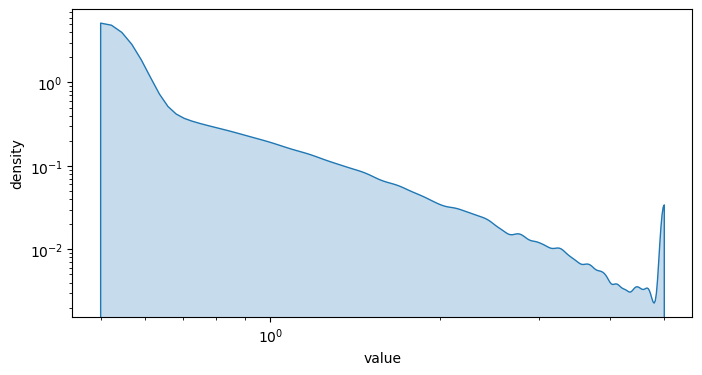

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

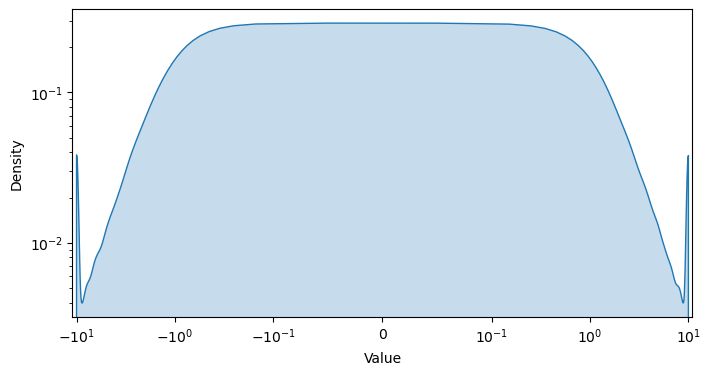

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

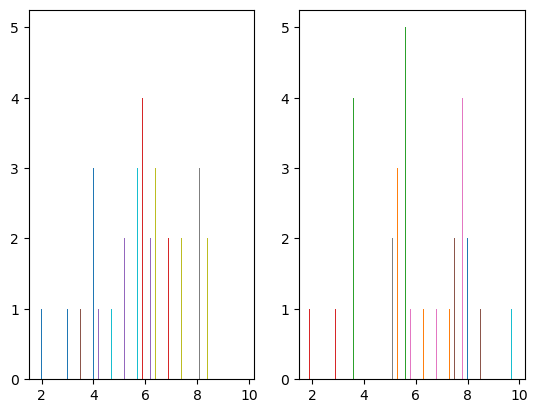

In [17]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


2.9705691505966945
1.2992322103492708


<AxesSubplot: >

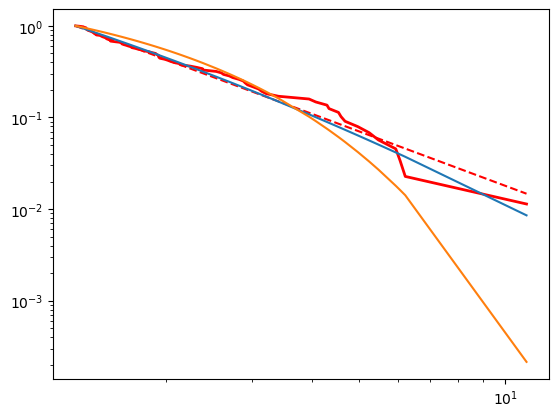

In [18]:
# fitting
import powerlaw
import numpy as np
data = np.random.pareto(3,size=1000) # data can be list or numpy array
fit = powerlaw.Fit(data)
print(fit.power_law.alpha)
print(fit.power_law.xmin)
R, p = fit.distribution_compare('power_law', 'exponential')
fig2 = fit.plot_ccdf(color = "r", linewidth = 2)
fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
fit.lognormal.plot_ccdf(ax=fig2)
fit.exponential.plot_ccdf(ax=fig2)